In [464]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import pickle, random
from tqdm import tqdm
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [465]:
#!pip install matplotlib

In [466]:
#df0 = pd.read_csv('../spreadsheets/rlhf_20250104_6.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_159nlp.csv') # Best
#df0 = pd.read_csv('../spreadsheets/rlhf_1064_2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_1072.csv') # 0.05, 0.95, 1.0, 0.999, 0.995, 12000
#df0 = pd.read_csv('../spreadsheets/shufled_rlhf_11rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_12rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_15rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_19rl.csv') # 0.005, 0.75, 0.1, 0.95, 0.999, 12000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_23rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_24rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_25rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_26rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_157nlp.csv') # 0.7, 0.95, 0.5, 0.999, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_29rl.csv') # 0.9, 0.9, 0.005, 0.95, 0.999, 10000, 0.9, 0.95, 1.0, 0.99, 0.99, 8000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_30rl.csv') # 
#df0 = pd.read_csv('../spreadsheets/rlhf_large_32rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_33rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_35rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_37rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_27rl2.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_38rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_42rl.csv') # 0.01, 0.99, 1.0, 0.95, 0.99, 16000
#df0 = pd.read_csv('../spreadsheets/rlhf_large_50rl.csv')
#df0 = pd.read_csv('../spreadsheets/rlhf_large_154nlp.csv')
df0 = pd.read_csv('../spreadsheets/rlhf_large_50rl_refined.csv')

In [467]:
df0.head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-compare,ask,bid,is_short,predicted_action,reward,refined-action,nlpreds
0,7.5550,7.5900,7.632502,7.778429,7.4320,1,7.4720,10915.0,7.737480,0,0,1,5427.356092,5487.643908,0,go_short,-1.015864,go_short,go_short
1,0.2359,0.2364,0.240455,0.248452,0.2279,1,0.2293,1666053.0,0.250244,0,0,1,821207.981298,844845.018702,0,go_long,0.152645,go_long,go_long
2,466.9200,467.8800,468.275102,469.299644,464.3600,1,465.2600,55118.0,468.740400,0,0,1,27509.923706,27608.076294,0,do_nothing,-0.195534,do_nothing,do_nothing
3,0.9484,0.9514,0.962078,0.977629,0.9165,1,0.9268,521270.0,0.974816,0,0,1,257632.805034,263637.194966,0,go_short,0.611403,go_long,go_short
4,722.6000,722.8500,722.984388,724.884388,713.8000,1,716.2000,646272.0,725.316000,0,0,1,321698.642202,324573.357798,0,do_nothing,-0.297188,do_nothing,do_nothing


In [468]:
df0['ask'] = df0['close'] * df0['volume']/(df0['close'] + df0['open'])

In [469]:
df0['bid'] = df0['open'] * df0['volume']/(df0['close'] + df0['open'])

In [470]:
df0.columns

Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask',
       'bid', 'is_short', 'predicted_action', 'reward', 'refined-action',
       'nlpreds'],
      dtype='object')

In [471]:
df0.head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-compare,ask,bid,is_short,predicted_action,reward,refined-action,nlpreds
0,7.5550,7.5900,7.632502,7.778429,7.4320,1,7.4720,10915.0,7.737480,0,0,1,5427.356092,5487.643908,0,go_short,-1.015864,go_short,go_short
1,0.2359,0.2364,0.240455,0.248452,0.2279,1,0.2293,1666053.0,0.250244,0,0,1,821207.981298,844845.018702,0,go_long,0.152645,go_long,go_long
2,466.9200,467.8800,468.275102,469.299644,464.3600,1,465.2600,55118.0,468.740400,0,0,1,27509.923706,27608.076294,0,do_nothing,-0.195534,do_nothing,do_nothing
3,0.9484,0.9514,0.962078,0.977629,0.9165,1,0.9268,521270.0,0.974816,0,0,1,257632.805034,263637.194966,0,go_short,0.611403,go_long,go_short
4,722.6000,722.8500,722.984388,724.884388,713.8000,1,716.2000,646272.0,725.316000,0,0,1,321698.642202,324573.357798,0,do_nothing,-0.297188,do_nothing,do_nothing


In [472]:
df0.columns

Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask',
       'bid', 'is_short', 'predicted_action', 'reward', 'refined-action',
       'nlpreds'],
      dtype='object')

In [473]:
#df0.drop(['Unnamed: 0'], axis=1, inplace=True)

In [474]:
df0['nlpreds'].value_counts()

nlpreds
go_long       564
do_nothing     27
go_short       20
Name: count, dtype: int64

In [475]:
#action_mapping = {"go_long": 0, "go_short": 1}

In [476]:
def prep_data(df: DataFrame) -> DataFrame:
    train_data = pd.DataFrame()
    for col in df.columns:
        col_name = col.split(' ')[0]
        train_data[f'{col_name}'] = df[col]

    return train_data

In [477]:
train_data = df0 #prep_data(df0)

In [478]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-compare,ask,bid,is_short,predicted_action,reward,refined-action,nlpreds
0,7.5550,7.5900,7.632502,7.778429,7.4320,1,7.4720,10915.0,7.737480,0,0,1,5427.356092,5487.643908,0,go_short,-1.015864,go_short,go_short
1,0.2359,0.2364,0.240455,0.248452,0.2279,1,0.2293,1666053.0,0.250244,0,0,1,821207.981298,844845.018702,0,go_long,0.152645,go_long,go_long


In [479]:
#train_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [480]:
new_cols = ['ask','bid','sma-compare','is_short']

In [481]:
# Encode actions into numerical values
action_mapping = {"go_long": 0, "go_short": 1, "do_nothing": 2}
train_data["action_num"] = train_data["nlpreds"].map(action_mapping)

In [482]:
train_data.head(2)

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-compare,ask,bid,is_short,predicted_action,reward,refined-action,nlpreds,action_num
0,7.5550,7.5900,7.632502,7.778429,7.4320,1,7.4720,10915.0,7.737480,0,0,1,5427.356092,5487.643908,0,go_short,-1.015864,go_short,go_short,1
1,0.2359,0.2364,0.240455,0.248452,0.2279,1,0.2293,1666053.0,0.250244,0,0,1,821207.981298,844845.018702,0,go_long,0.152645,go_long,go_long,0


In [483]:
# Define RL parameters
#states = train_data[["sma-05", "sma-07", "sma-25", "sma-compare", "is_short"]].values  # Include binary_state
states = train_data[new_cols].values
actions = list(action_mapping.values())  # Action space
rewards = train_data["reward"].values  # Rewards
n_states = states.shape[0]
n_actions = len(actions)

In [484]:
# Initialize Q-table
q_table = np.zeros((n_states, n_actions))

In [485]:
Hyperparameters = [
    [0.1, 0.9, 0.1, 0.99, 0.995, 4000],
    [0.005, 0.75, 0.1, 0.95, 0.999, 12000],
    [0.001, 0.75, 1.0, 0.99, 0.99, 30000],
    [1, 0.75, 0.005, 0.95, 0.95, 22000],
    [0.01, 0.99, 1.0, 0.95, 0.99, 16000],
    [0.7, 0.99, 1.0, 0.95, 0.997, 8000],
    [0.01, 0.95, 1.0, 0.997, 0.995, 26000],
    [0.25, 0.95, 0.01, 0.997, 0.999, 14000],
    [0.5, 0.85, 0.5, 0.997, 0.997, 14000],
    [0.01, 0.85, 0.01, 0.95, 0.95, 12000],
    [0.9, 0.99, 0.5, 0.995, 0.95, 12000],
    [0.05, 0.9, 0.5, 0.95, 0.999, 4000],
    [0.05, 0.99, 0.5, 0.99, 0.997, 6000],
    [1, 0.75, 0.05, 0.999, 0.999, 10000],
    [0.9, 0.95, 1.0, 0.99, 0.99, 8000],
    [0.25, 0.75, 0.01, 0.995, 0.999, 20000],
    [0.3, 0.75, 1.0, 0.995, 0.99, 10000],
    [1, 0.9, 1.0, 0.999, 0.999, 10000],
    [0.7, 0.75, 1.0, 0.97, 0.999, 28000],
    [0.05, 0.95, 1.0, 0.999, 0.995, 12000],
    [0.7, 0.95, 0.5, 0.999, 0.99, 16000],
    [0.25, 0.95, 1.0, 0.99, 0.99, 10000],
    [0.25, 0.99, 0.01, 0.997, 0.99, 8000],
    [1, 0.95, 0.1, 0.96, 0.96, 12000],
    [0.9, 0.9, 0.005, 0.95, 0.999, 10000],
    [1, 0.9, 1.0, 0.99, 0.99, 11000]





]

#print(*Hyperparameters[0])
'''
alpha = 1
gamma = 0.95
epsilon = 0.1
min_epsilon = 0.96
decay_rate = 0.96
n_episodes = 12000
'''

alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes = Hyperparameters[14] # Hyperparameters[9] # Hyperparameters[22] #Hyperparameters[6]



In [486]:
def create_state_index_mapping(df):
    state_to_index = {}
    for idx, row in df.iterrows():
        state = (row['ask'], row['bid'], row['sma-compare'], row['is_short'])
        state_to_index[state] = idx
    return state_to_index

# Assuming 'df' is your dataframe used during training
state_to_index = create_state_index_mapping(train_data)

# Save the state_to_index dictionary for later use
np.save('bids_state_to_index.npy', state_to_index)


In [487]:
# Helper function to choose an action using epsilon-greedy
def choose_action(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(q_table[state])  # Exploit: best known action

evaluating results per episode ...:   1%|          | 99/8000 [00:00<00:16, 487.44it/s]

Episode 0/8000 - Total Reward: 155.74633904, Epsilon: 0.99


evaluating results per episode ...:   6%|▌         | 495/8000 [00:00<00:13, 544.38it/s]

Episode 400/8000 - Total Reward: 157.78775594, Epsilon: 0.99


evaluating results per episode ...:  11%|█         | 890/8000 [00:01<00:13, 540.74it/s]

Episode 800/8000 - Total Reward: 81.89862157000005, Epsilon: 0.99


evaluating results per episode ...:  16%|█▌        | 1286/8000 [00:02<00:12, 552.75it/s]

Episode 1200/8000 - Total Reward: 41.28765234000004, Epsilon: 0.99


evaluating results per episode ...:  21%|██        | 1675/8000 [00:03<00:12, 525.92it/s]

Episode 1600/8000 - Total Reward: 84.54427365000001, Epsilon: 0.99


evaluating results per episode ...:  26%|██▌       | 2079/8000 [00:03<00:10, 565.73it/s]

Episode 2000/8000 - Total Reward: 162.07679209999998, Epsilon: 0.99


evaluating results per episode ...:  32%|███▏      | 2538/8000 [00:04<00:11, 462.79it/s]

Episode 2400/8000 - Total Reward: 99.64709126, Epsilon: 0.99


evaluating results per episode ...:  37%|███▋      | 2947/8000 [00:05<00:11, 454.43it/s]

Episode 2800/8000 - Total Reward: 156.49430114000003, Epsilon: 0.99


evaluating results per episode ...:  41%|████      | 3299/8000 [00:06<00:10, 434.02it/s]

Episode 3200/8000 - Total Reward: 89.87275952000002, Epsilon: 0.99


evaluating results per episode ...:  46%|████▌     | 3665/8000 [00:07<00:08, 519.82it/s]

Episode 3600/8000 - Total Reward: 48.12375639000001, Epsilon: 0.99


evaluating results per episode ...:  52%|█████▏    | 4124/8000 [00:08<00:08, 480.50it/s]

Episode 4000/8000 - Total Reward: 90.18043253000009, Epsilon: 0.99


evaluating results per episode ...:  56%|█████▋    | 4502/8000 [00:08<00:06, 528.70it/s]

Episode 4400/8000 - Total Reward: 124.51570688000001, Epsilon: 0.99


evaluating results per episode ...:  61%|██████    | 4870/8000 [00:09<00:06, 503.23it/s]

Episode 4800/8000 - Total Reward: 28.70237494, Epsilon: 0.99


evaluating results per episode ...:  66%|██████▋   | 5307/8000 [00:10<00:05, 487.05it/s]

Episode 5200/8000 - Total Reward: 41.258077229999984, Epsilon: 0.99


evaluating results per episode ...:  71%|███████   | 5697/8000 [00:11<00:04, 494.70it/s]

Episode 5600/8000 - Total Reward: 135.39197421000003, Epsilon: 0.99


evaluating results per episode ...:  76%|███████▌  | 6078/8000 [00:11<00:03, 529.73it/s]

Episode 6000/8000 - Total Reward: 110.49562335000005, Epsilon: 0.99


evaluating results per episode ...:  81%|████████  | 6485/8000 [00:12<00:02, 561.64it/s]

Episode 6400/8000 - Total Reward: 121.60462381000002, Epsilon: 0.99


evaluating results per episode ...:  86%|████████▌ | 6873/8000 [00:13<00:02, 547.59it/s]

Episode 6800/8000 - Total Reward: 56.405452810000014, Epsilon: 0.99


evaluating results per episode ...:  91%|█████████ | 7285/8000 [00:14<00:01, 560.38it/s]

Episode 7200/8000 - Total Reward: 60.01449293, Epsilon: 0.99


evaluating results per episode ...:  96%|█████████▌| 7673/8000 [00:14<00:00, 530.64it/s]

Episode 7600/8000 - Total Reward: 112.91134899000005, Epsilon: 0.99


evaluating results per episode ...: 100%|██████████| 8000/8000 [00:15<00:00, 515.97it/s]


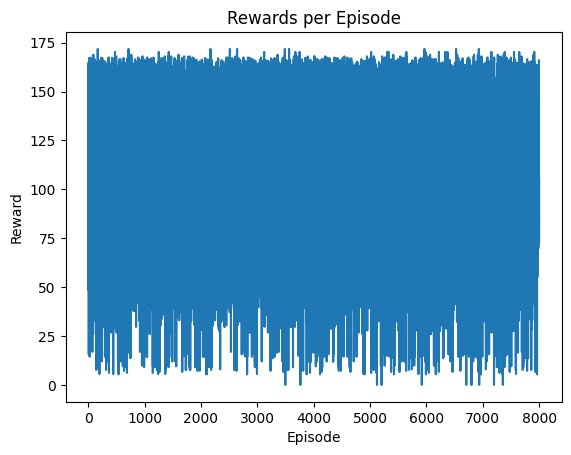

In [488]:

# Set random seed for reproducibility and train the loop
np.random.seed(42)
random.seed(42)
# Initialize a list to store rewards per episode
rewards_per_episode = []

for episode in tqdm(range(n_episodes), desc="evaluating results per episode ..."):
    current_state = np.random.randint(0, n_states)  # Random initial state
    total_reward = 0  # Initialize total reward for the current episode

    while current_state < n_states - 1:
        action = choose_action(current_state, epsilon)
        
        next_state = current_state + 1  # This depends on your environment logic
        reward = rewards[next_state]

        best_next_action = np.argmax(q_table[next_state])
        q_table[current_state, action] += alpha * (
            reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
        )
        
        total_reward += reward  # Accumulate reward for the current episode
        current_state = next_state  # Move to next state

    rewards_per_episode.append(total_reward)  # Store the total reward for the current episode

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * decay_rate)

    # Optional: Log progress
    if episode % 400 == 0:  # Adjust logging frequency as needed
        print(f"Episode {episode}/{n_episodes} - Total Reward: {total_reward}, Epsilon: {epsilon}")

# Example: Save the Q-table
np.save("bids_q_table.npy", q_table)

# Example: Plotting the rewards
import matplotlib.pyplot as plt

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()



In [489]:
def load_q_table(file_path):
    return np.load(file_path)

def load_state_index_mapping(file_path):
    return np.load(file_path, allow_pickle=True).item()

loaded_mapping = load_state_index_mapping(file_path="bids_state_to_index.npy")
loaded_qtable = load_q_table(file_path="bids_q_table.npy")

In [490]:
#state = (row['open'], row['high'], row['ema-26'], row['ema-12'], row['low'], \
#                 row['mean-grad-hist'], row['close'], row['volume'], row['sma-25'], \
#                 row['long_jcrosk'], row['short_kdj'], row['sma-compare'], row['is_short'])

def prep_state(
                ask: float, bid: float, sma_compare: int, is_short: int
            ):
    state = np.array([[ask, bid, sma_compare, is_short]])
    if not np.all(np.isfinite(state)):
        state = np.nan_to_num(state, nan=0.0, posinf=0.0, neginf=0.0)
    return state


In [491]:

def predict_action(state, q_table, state_to_index, action_mapping, default_action: str = None):
    state_tuple = tuple(state.flatten())

    state_index = state_to_index.get(state_tuple, -1)

    if not state_index == -1:
        try:
            q_values = q_table[state_index]
        except ValueError as e:
            print(e)
            #return default_action
    else:
        state_tuples = list(state_to_index.keys())
        kdtree = KDTree(state_tuples)
        distance, index = kdtree.query(state.flatten())
        nearest_state_tuple = state_tuples[index]
        new_state_index = state_to_index[nearest_state_tuple]
        q_values = loaded_qtable[new_state_index]
    
    #q_values = q_table[state_index]
    best_action_index = np.argmax(q_values)
    action = [action for action, index in action_mapping.items() if index == best_action_index][0]
    return action

In [492]:
# Predict an entire range
def predict_range(df: DataFrame = train_data) -> DataFrame:
    for idx, row in df.iterrows():
        state = row[['ask','bid','sma-compare', 'is_short']].values
        action = predict_action(state, q_table, state_to_index, action_mapping)
        df.loc[idx, "predicted_action"] = action
    return df

In [493]:
train_data = predict_range(train_data)

In [494]:
train_data['predicted_action'].value_counts()

predicted_action
go_long       564
do_nothing     27
go_short       20
Name: count, dtype: int64

In [495]:
m = train_data[(train_data['predicted_action'] == 'go_long') & (train_data['reward'] > 0)]
m['is_short'].value_counts()

is_short
0    168
1     82
Name: count, dtype: int64

In [496]:
longs = dict(m['is_short'].value_counts().items()).get(0)
print(longs)
shorts = dict(m['is_short'].value_counts().items()).get(1)
print(shorts)

168
82


In [497]:
# Performance measures
# Initialize cumulative rewards
cumulative_predicted_reward = 0
cumulative_actual_reward = 0

# Iterate through states to calculate rewards
for state_index in range(n_states - 1):
    # Predicted action from Q-table
    predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
    # Actual action from the ground truth
    actual_action = train_data["action_num"].iloc[state_index]

    # Get reward for predicted action only if it matches the actual action
    if predicted_action == actual_action:
        predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
        cumulative_predicted_reward += predicted_reward

    # Get actual reward for the ground truth action
    actual_reward = rewards[state_index + 1]
    cumulative_actual_reward += actual_reward

    # Optional: Log progress
    if state_index % 100 == 0:  # Adjust logging frequency as needed
        print(f"Processed state {state_index}/{n_states - 1}")
        print(f"Current Predicted Reward: {cumulative_predicted_reward}")
        print(f"Current Actual Reward: {cumulative_actual_reward}")

# Print results
print(f"Cumulative Predicted Reward: {cumulative_predicted_reward}")
print(f"Cumulative Actual Reward: {cumulative_actual_reward}")

# Optionally calculate efficiency
efficiency = (
    ((cumulative_predicted_reward - cumulative_actual_reward) / abs(cumulative_actual_reward)) * 100
    if cumulative_actual_reward != 0
    else 0
)
print(f"Prediction Efficiency: {efficiency:.2f}%")



Processed state 0/610
Current Predicted Reward: 0.15264496
Current Actual Reward: 0.15264496
Processed state 100/610
Current Predicted Reward: -117.05572451999998
Current Actual Reward: -117.05572451999998
Processed state 200/610
Current Predicted Reward: -87.20088318999993
Current Actual Reward: -87.20088318999993
Processed state 300/610
Current Predicted Reward: -38.02966268999997
Current Actual Reward: -38.02966268999997
Processed state 400/610
Current Predicted Reward: -23.82057291999996
Current Actual Reward: -23.82057291999996
Processed state 500/610
Current Predicted Reward: -31.016977259999937
Current Actual Reward: -31.016977259999937
Processed state 600/610
Current Predicted Reward: 31.824990830000047
Current Actual Reward: 31.824990830000047
Cumulative Predicted Reward: 39.792940520000045
Cumulative Actual Reward: 39.792940520000045
Prediction Efficiency: 0.00%


In [498]:
# Accuracy
correct_predictions = 0
for state_index in range(n_states):
    predicted_action = np.argmax(q_table[state_index])  # Predicted action
    actual_action = train_data["action_num"].iloc[state_index]  # Actual action
    if predicted_action == actual_action:
        correct_predictions += 1

accuracy = correct_predictions / n_states
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


In [499]:
# Confusion matrix
y_true = train_data["action_num"]  # Actual actions
y_pred = [np.argmax(q_table[state_index]) for state_index in range(n_states)]  # Predicted actions

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[564   0   0]
 [  0  20   0]
 [  0   0  27]]


In [500]:
def confusion_accuracy(conf_matrix, n_states):
    # True Positives (TP): Diagonal elements of the confusion matrix
    TP = conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2]
    # **True Positives**: 16 (class 0), 0 (class 1), 0 (class 2)
    return TP*100/n_states

In [501]:
con_acc = confusion_accuracy(cm, n_states=n_states)
print(f"confusion accuracy: {con_acc:.2f}%")

confusion accuracy: 100.00%


In [502]:
df0['predicted_action'].value_counts()

predicted_action
go_long       564
do_nothing     27
go_short       20
Name: count, dtype: int64

In [519]:
def action_reward(action: str, is_short: int):
    m = train_data[(train_data['predicted_action'] == f'{action}') & (train_data['is_short'] == is_short)]
    counts = m['is_short'].value_counts()
    total_reward = m['reward'].cumsum()[-1:].values[0]
    wins = len(m[m['reward'] > 0])
    losses = len(m[m['reward'] <= 0])
    return {
        'counts': counts.get(is_short),
        'total reward': total_reward,
        'winrate': f'{wins * 100 / (losses + wins):.2f}%',
        'per trade profit': m[m['reward'] > 0]['reward'].sum() / wins,
        'per trade loss': m[m['reward'] <= 0]['reward'].sum() / losses
    }

In [523]:
print(action_reward('go_short', 1)) # go_short 1

{'counts': 3, 'total reward': 3.0598498000000003, 'winrate': '66.67%', 'per trade profit': 1.6933399, 'per trade loss': -0.32683}


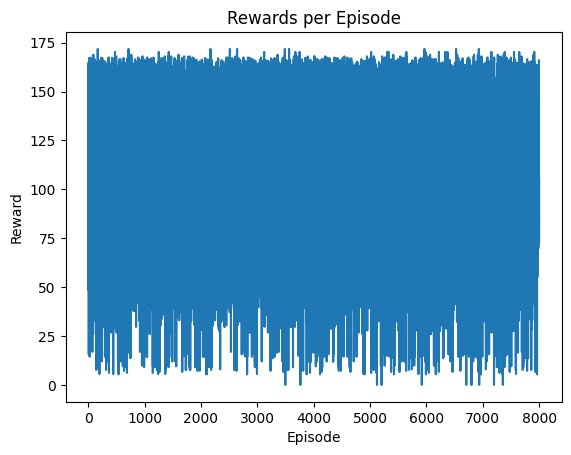

In [505]:
import matplotlib.pyplot as plt

# Assuming you have a list of rewards for each episode
#rewards_per_episode = [...]  # Populate this with your actual data

plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.show()


In [506]:
# Tuning

def train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards):
    q_table = np.zeros((n_states, n_actions))
    rewards_per_episode = []

    for episode in range(n_episodes):
        current_state = np.random.randint(0, n_states)
        total_reward = 0

        while current_state < n_states - 1:
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, n_actions)
            else:
                action = np.argmax(q_table[current_state])

            next_state = current_state + 1  # Adjust based on environment logic
            reward = rewards[next_state]

            best_next_action = np.argmax(q_table[next_state])
            q_table[current_state, action] += alpha * (
                reward + gamma * q_table[next_state, best_next_action] - q_table[current_state, action]
            )

            total_reward += reward
            current_state = next_state

        rewards_per_episode.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate) # default min_epsilon = 0.01

    return q_table, rewards_per_episode


In [507]:

def evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards):
    correct_predictions = 0
    total_reward = 0
    reward_weighted_accuracy = []

    # Add tqdm for progress visualization
    for state_index in tqdm(range(n_states), desc="Evaluating States"):
        predicted_action = np.argmax(q_table[state_index])  # Predicted action
        actual_action = train_data["action_num"].iloc[state_index]  # Actual action
        reward = rewards[state_index]  # Reward for the action

        if predicted_action == actual_action:
            correct_predictions += 1
            total_reward += reward

        accuracy = correct_predictions / (state_index + 1)
        reward_weighted_accuracy.append(total_reward / (state_index + 1))

        # Optional: Log progress
        if state_index % 100 == 0:
            print(f"Processed state {state_index}/{n_states} - Accuracy: {accuracy * 100:.2f}%, Reward-weighted Accuracy: {reward_weighted_accuracy[-1]}")

    final_reward_weighted_accuracy = total_reward / n_states
    return final_reward_weighted_accuracy * 100



In [508]:
'''
def random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_reward_weighted_accuracy = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)

        if reward_weighted_accuracy > best_reward_weighted_accuracy:
            best_reward_weighted_accuracy = reward_weighted_accuracy
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration Reward-weighted Accuracy: {reward_weighted_accuracy:.2f}%, Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

    return best_params, best_reward_weighted_accuracy

# Define the parameter grid
param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000]
}

# Perform Random Search
best_params, best_reward_weighted_accuracy = random_search_reward_weighted(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Reward-weighted Accuracy: {best_reward_weighted_accuracy:.2f}%")

'''

'\ndef random_search_reward_weighted(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_reward_weighted_accuracy = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        reward_weighted_accuracy = evaluate_q_learning_reward_weighted(q_table, n_states, train_data, rewards)\n\n        if reward_weighted_accuracy > best_reward_weighted_accuracy:\n            best_reward_weighted_accuracy = reward_weighted_accuracy\n        

In [509]:
def evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards):
    # Initialize cumulative rewards
    cumulative_predicted_reward = 0
    cumulative_actual_reward = 0

    # Iterate through states to calculate rewards
    for state_index in range(n_states - 1):
        # Predicted action from Q-table
        predicted_action = np.argmax(q_table[state_index])  # Best action for the current state
        # Actual action from the ground truth
        actual_action = train_data["action_num"].iloc[state_index]

        # Get reward for predicted action only if it matches the actual action
        if predicted_action == actual_action:
            predicted_reward = rewards[state_index + 1]  # Reward for the correct prediction
            cumulative_predicted_reward += predicted_reward

        # Get actual reward for the ground truth action
        actual_reward = rewards[state_index + 1]
        cumulative_actual_reward += actual_reward
    return cumulative_predicted_reward

In [510]:
train_data.columns

Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask',
       'bid', 'is_short', 'predicted_action', 'reward', 'refined-action',
       'nlpreds', 'action_num'],
      dtype='object')

In [511]:
'''
def random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):
    best_params = None
    best_cumulative_pred_reward = float('-inf')

    for _ in tqdm(range(n_iter), desc="Searching for params ..."):
        alpha = random.choice(param_grid['alpha'])
        gamma = random.choice(param_grid['gamma'])
        epsilon = random.choice(param_grid['epsilon'])
        min_epsilon = random.choice(param_grid['decay_rate'])
        decay_rate = random.choice(param_grid['decay_rate'])
        n_episodes = random.choice(param_grid['n_episodes'])

        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)
        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)

        if cumulative_pred_reward > best_cumulative_pred_reward:
            best_cumulative_pred_reward = cumulative_pred_reward
            best_params = (alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes)

        print(f"Iteration cumulative predicted reward: {cumulative_pred_reward:.2f}%, Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")

    return best_params, best_cumulative_pred_reward

# Define the parameter grid
param_grid = {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1],
    'gamma': [0.75, 0.85, 0.9, 0.95, 0.99],
    'epsilon': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005],
    'min_epsilon': [0.05, 0.01, 0.005, 0.001, 0.001],
    'decay_rate': [0.95, 0.99, 0.995, 0.997, 0.999],
    'n_episodes': [1500, 4000,6000, 8000, 9000, 10000, 11000, 12000, 14000, 16000, 18000, 20000, 22000, 24000, 26000, 28000, 30000]
}
# 1500, 4000,6000, 8000, 9000, 10000, 11000, 
# Perform Random Search
best_params, best_cumulative_pred_reward = random_search_prediction_efficiency(50, param_grid, n_states, n_actions, rewards, train_data)
print(f"Best Hyperparameters: {best_params}")
print(f"Best cumulative predicted reward: {best_cumulative_pred_reward:.2f}%")
'''

'\ndef random_search_prediction_efficiency(n_iter, param_grid, n_states, n_actions, rewards, train_data):\n    best_params = None\n    best_cumulative_pred_reward = float(\'-inf\')\n\n    for _ in tqdm(range(n_iter), desc="Searching for params ..."):\n        alpha = random.choice(param_grid[\'alpha\'])\n        gamma = random.choice(param_grid[\'gamma\'])\n        epsilon = random.choice(param_grid[\'epsilon\'])\n        min_epsilon = random.choice(param_grid[\'decay_rate\'])\n        decay_rate = random.choice(param_grid[\'decay_rate\'])\n        n_episodes = random.choice(param_grid[\'n_episodes\'])\n\n        q_table, _ = train_q_learning(alpha, gamma, epsilon, min_epsilon, decay_rate, n_episodes, n_states, n_actions, rewards)\n        cumulative_pred_reward = evaluate_q_learning_prediction_efficiency(q_table, n_states, train_data, rewards)\n\n        if cumulative_pred_reward > best_cumulative_pred_reward:\n            best_cumulative_pred_reward = cumulative_pred_reward\n        

In [512]:
#colsa = ['ask','bid','sma-05', 'sma-07', 'sma-25','sma-compare','is_short', 'action', 'nlpreds', 'predicted_action','reward']
colsa = ['open', 'high', 'ema-26', 'ema-12', 'low', \
            'mean-grad-hist', 'close', 'volume', 'sma-25', 'long_jcrosk', 'short_kdj', \
            'sma-compare', 'ask', 'bid', 'is_short', 'predicted_action', 'reward'
        ]
learn_df = train_data[colsa]

In [513]:
def split_action(action: str):
    return ' '.join(action.split('_'))

In [514]:
#learn_df.loc[:,['predicted_action']] = learn_df['predicted_action'] #.apply(split_action)

In [515]:
learn_df.head()

,open,high,ema-26,ema-12,low,mean-grad-hist,close,volume,sma-25,long_jcrosk,short_kdj,sma-compare,ask,bid,is_short,predicted_action,reward
0,7.5550,7.5900,7.632502,7.778429,7.4320,1,7.4720,10915.0,7.737480,0,0,1,5427.356092,5487.643908,0,go_short,-1.015864
1,0.2359,0.2364,0.240455,0.248452,0.2279,1,0.2293,1666053.0,0.250244,0,0,1,821207.981298,844845.018702,0,go_long,0.152645
2,466.9200,467.8800,468.275102,469.299644,464.3600,1,465.2600,55118.0,468.740400,0,0,1,27509.923706,27608.076294,0,do_nothing,-0.195534
3,0.9484,0.9514,0.962078,0.977629,0.9165,1,0.9268,521270.0,0.974816,0,0,1,257632.805034,263637.194966,0,go_short,0.611403
4,722.6000,722.8500,722.984388,724.884388,713.8000,1,716.2000,646272.0,725.316000,0,0,1,321698.642202,324573.357798,0,do_nothing,-0.297188


In [516]:
learn_df.to_csv('/home/defi/Desktop/portfolio/projects/python/pipeline_defi/lean_df_54rl.csv', index=False)

In [517]:
learn_df.columns

Index(['open', 'high', 'ema-26', 'ema-12', 'low', 'mean-grad-hist', 'close',
       'volume', 'sma-25', 'long_jcrosk', 'short_kdj', 'sma-compare', 'ask',
       'bid', 'is_short', 'predicted_action', 'reward'],
      dtype='object')